In [1]:
import os
import shutil
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [2]:
# Base data directory
base_dir = Path('/Users/tehreem/Desktop/Study/Projects/SDS-CP028-smart-leaf/submissions/team-members/tehreem-ansari/data')
source_dir = base_dir / 'ValidCrops'
target_dirs = {
    'train': base_dir / 'train',
    'val': base_dir / 'val',
    'test': base_dir / 'test'
}

In [3]:
#Remove Corrupt Images
def remove_corrupt_images(directory):
    corrupted_files = []
    for dirpath, _, filenames in os.walk(directory):
        for filename in filenames:
            normalized_name = filename.strip().lower()
            if normalized_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                file_path = os.path.join(dirpath, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                except Exception as e:
                    corrupted_files.append(file_path)
                    print(f"Corrupt image found and deleted: {file_path} ({e})")
                    os.remove(file_path)
            else:
                print(f"Unknown file format ignoring: {filename}")
    print(f"Total corrupt images deleted: {len(corrupted_files)}")



remove_corrupt_images(source_dir)

Unknown file format ignoring: .DS_Store
Unknown file format ignoring: .DS_Store
Unknown file format ignoring: .DS_Store
Unknown file format ignoring: DOC-20231219-WA0001.pdf
Total corrupt images deleted: 0


In [4]:
# Create target dirs
for split_dir in target_dirs.values():
    os.makedirs(split_dir, exist_ok=True)

# Function to get all image file paths
def get_images(path):
    return [file for file in path.iterdir() if file.is_file() and file.suffix.lower() in ['.jpg', '.jpeg', '.png']]

# Walk through each category (corn, rice, etc.)
for crop_folder in source_dir.iterdir():
    if crop_folder.is_dir():
        for disease_folder in crop_folder.iterdir():
            if disease_folder.is_dir():
                images = get_images(disease_folder)
                random.shuffle(images)

                # Split images
                total = len(images)
                train_end = int(0.8 * total)
                val_end = int(0.9 * total)

                split_data = {
                    'train': images[:train_end],
                    'val': images[train_end:val_end],
                    'test': images[val_end:]
                }

                # Copy images to new folders
                class_name = disease_folder.name
                for split, image_list in split_data.items():
                    class_dir = target_dirs[split] / class_name
                    os.makedirs(class_dir, exist_ok=True)
                    for image_path in image_list:
                        shutil.copy(image_path, class_dir / image_path.name)

print("Data split and copied successfully.")


Data split and copied successfully.


In [24]:
#Create the dataframes from directories
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # standard size for CNNs

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=target_dirs['train'],
    labels="inferred",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=target_dirs['val'],
    labels="inferred",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=target_dirs['test'],
    labels="inferred",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 10653 files belonging to 14 classes.
Found 1301 files belonging to 14 classes.
Found 1309 files belonging to 14 classes.


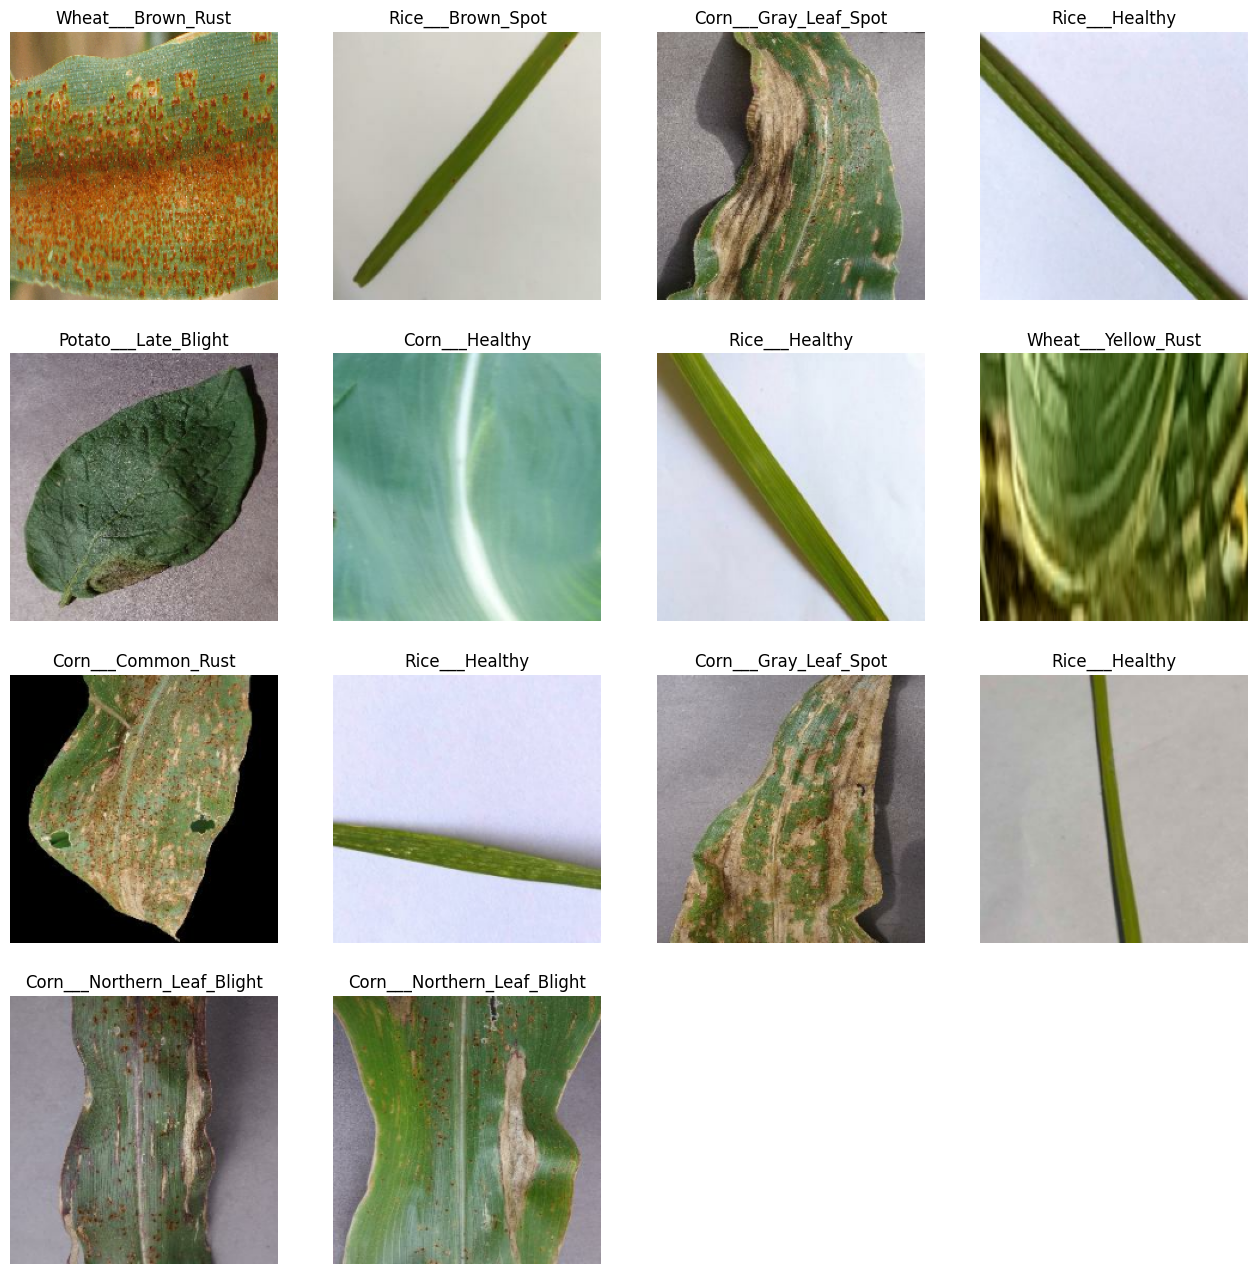

In [13]:
class_names = train_ds.class_names

plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(14):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

2025-05-02 17:40:53.634881: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


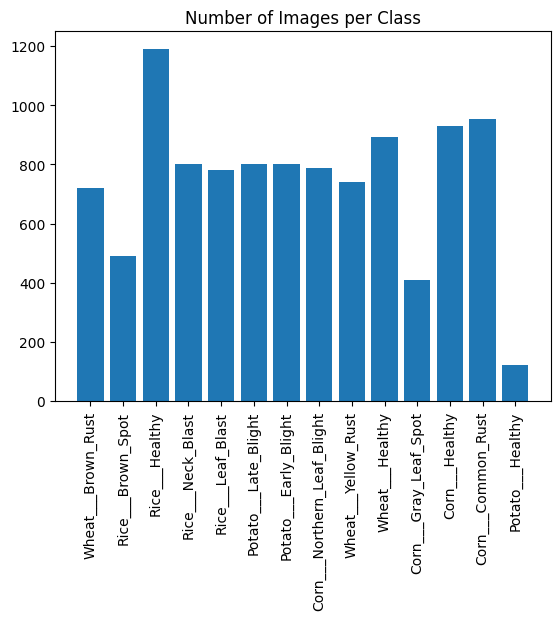

In [14]:
# Class histogram
# Counting from dataset (this is slow)
from collections import Counter
label_counter = Counter()
for _, labels in train_ds:
    label_counter.update(labels.numpy())

# Convert index-based counts to class-name-based counts
image_counts = {class_names[i]: count for i, count in label_counter.items()}


def print_count_of_classes(class_counts):
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=90)
    plt.title("Number of Images per Class")
    plt.show()

print_count_of_classes(image_counts)

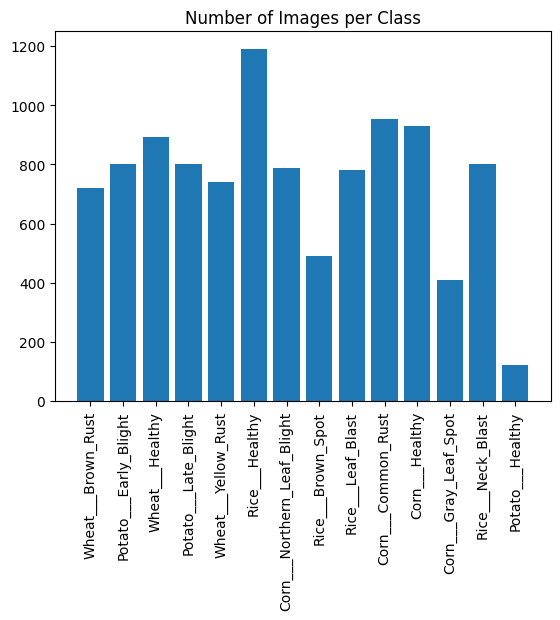

In [16]:
# Counting from directory instead of dataset, this is fast
def count_images_in_train(train_dir):
    image_counts = {}
    # Traverse through all class directories in train
    for class_dir in train_dir.iterdir():
        if class_dir.is_dir():
            # Count the images in each class folder
            image_count = len([file for file in class_dir.iterdir() if file.is_file() and file.suffix.lower() in ['.jpg', '.jpeg', '.png']])
            image_counts[class_dir.name] = image_count
    
    return image_counts

# Get image count for each class in train set
image_counts2 = count_images_in_train(target_dirs['train'])

# Print the image count for each class
# for class_name, count in image_counts.items():
#     print(f"{class_name}: {count} images")
    
print_count_of_classes(image_counts2)

In [18]:
# Normalize pixel values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

#Verifying if normalization has happened
for images, labels in train_ds.take(1):
    print("Pixel range:", tf.reduce_min(images).numpy(), "-", tf.reduce_max(images).numpy())
    print("Example pixel:", images[0, 0, 0].numpy())  # Top-left pixel of the first image



Pixel range: 0.0 - 0.003921569
Example pixel: [0.00168403 0.00203774 0.00080745]


In [19]:
# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=30,           # Randomly rotate images up to 30 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20% of height
    zoom_range=0.2,              # Randomly zoom in/out by up to 20%
    shear_range=0.2,             # Shear transformations up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill in new pixels after transformations with nearest pixel values
)

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
import shutil  # for copying files

def augment_images(source_dir, save_dir, datagen, target_count, number_of_copy, keep_original=False):
    image_count = 0
    
    for image_file in source_dir.glob('*.JPG'):
        if image_count >= target_count:
            break

        # Save original image if requested
        if keep_original:
            dest_file = save_dir / image_file.name
            if not dest_file.exists():
                shutil.copy(image_file, dest_file)
                image_count += 1
                if image_count >= target_count:
                    break

        # Load image and prepare for augmentation
        img = load_img(image_file)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate augmented images per original
        i = 0
        for batch in datagen.flow(x, batch_size=1,
                                  save_to_dir=save_dir,
                                  save_prefix='aug',
                                  save_format='JPG'):
            i += 1
            image_count += 1
            if image_count >= target_count or i >= number_of_copy:
                break


In [21]:
#Use augmentation to increase number of samples in Potato___Healthy 
potato_class = 'Potato___Healthy'
source_dir = target_dirs['train']/potato_class  # change to your dataset path
save_dir = source_dir
target_count = 2 * len(list(source_dir.glob('*.JPG')))  # Double the dataset

augment_images(source_dir, save_dir, datagen, target_count, 2)

Wheat___Brown_Rust: 721 images
Potato___Early_Blight: 800 images
Wheat___Healthy: 892 images
Potato___Late_Blight: 800 images
Wheat___Yellow_Rust: 739 images
Rice___Healthy: 1190 images
Corn___Northern_Leaf_Blight: 788 images
Rice___Brown_Spot: 490 images
Rice___Leaf_Blast: 781 images
Corn___Common_Rust: 953 images
Corn___Healthy: 929 images
Corn___Gray_Leaf_Spot: 410 images
Rice___Neck_Blast: 800 images
Potato___Healthy: 360 images


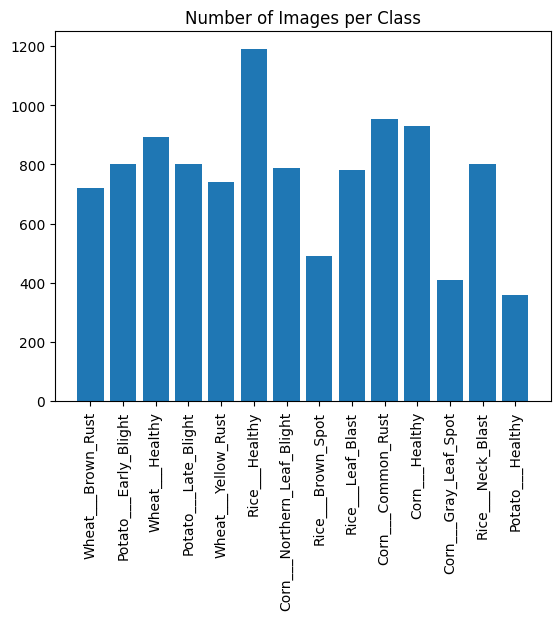

In [22]:
#rechecking after augmentation
# Get image count for each class in train set
image_counts = count_images_in_train(target_dirs['train'])

# Print the image count for each class
for class_name, count in image_counts.items():
    print(f"{class_name}: {count} images")
print_count_of_classes(image_counts)

In [32]:
#Define the CNN
DROPOUT_RATE = 0.3

from tensorflow.keras import layers, models

num_classes = len(class_names)

model = models.Sequential([
    layers.InputLayer(shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(DROPOUT_RATE), # and keep_prob=0.7
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       692,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 730,574 (2.79 MB)

 Trainable params: 730,574 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
#compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [37]:
#Set Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [38]:
#Train the model
#We have 10,656 training images, and a batch size of 32, then: ceil(10656 / 32) = 333
#Tensorflow computes: steps_per_epoch = math.ceil(total_training_samples / batch_size)

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 100s 301ms/step - accuracy: 0.5144 - loss: 1.3139 - val_accuracy: 0.6418 - val_loss: 0.9738
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 106s 317ms/step - accuracy: 0.5690 - loss: 1.1762 - val_accuracy: 0.6818 - val_loss: 0.8547
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 4580s 14s/step - accuracy: 0.6342 - loss: 0.9927 - val_accuracy: 0.6733 - val_loss: 0.8721
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 27570s 83s/step - accuracy: 0.6612 - loss: 0.8831 - val_accuracy: 0.7225 - val_loss: 0.7336
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 23470s 71s/step - accuracy: 0.7155 - loss: 0.7847 - val_accuracy: 0.7640 - val_loss: 0.6585
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 21937s 66s/step - accuracy: 0.7405 - loss: 0.6858 - val_accuracy: 0.7540 - val_loss: 0.6896
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 7197s 22s/step - accuracy: 0.7587 - loss: 0.6242 - val_accuracy: 0.7763 - val_loss: 0.5652
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 95s 284ms/step - accuracy: 0.7734 - lo

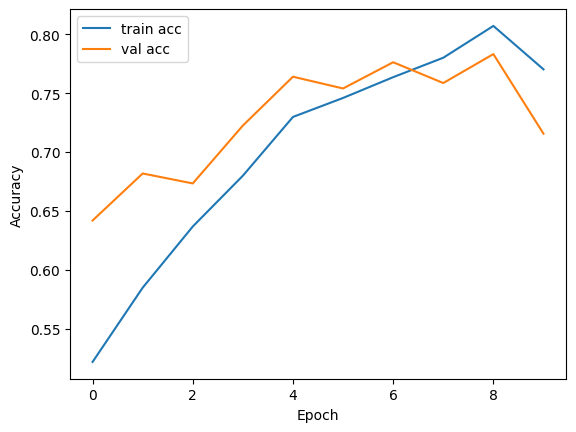

In [39]:
#Plot Training History
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
#Evaluate Model on Validation Set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8053 - loss: 0.4904
Validation accuracy: 0.78


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


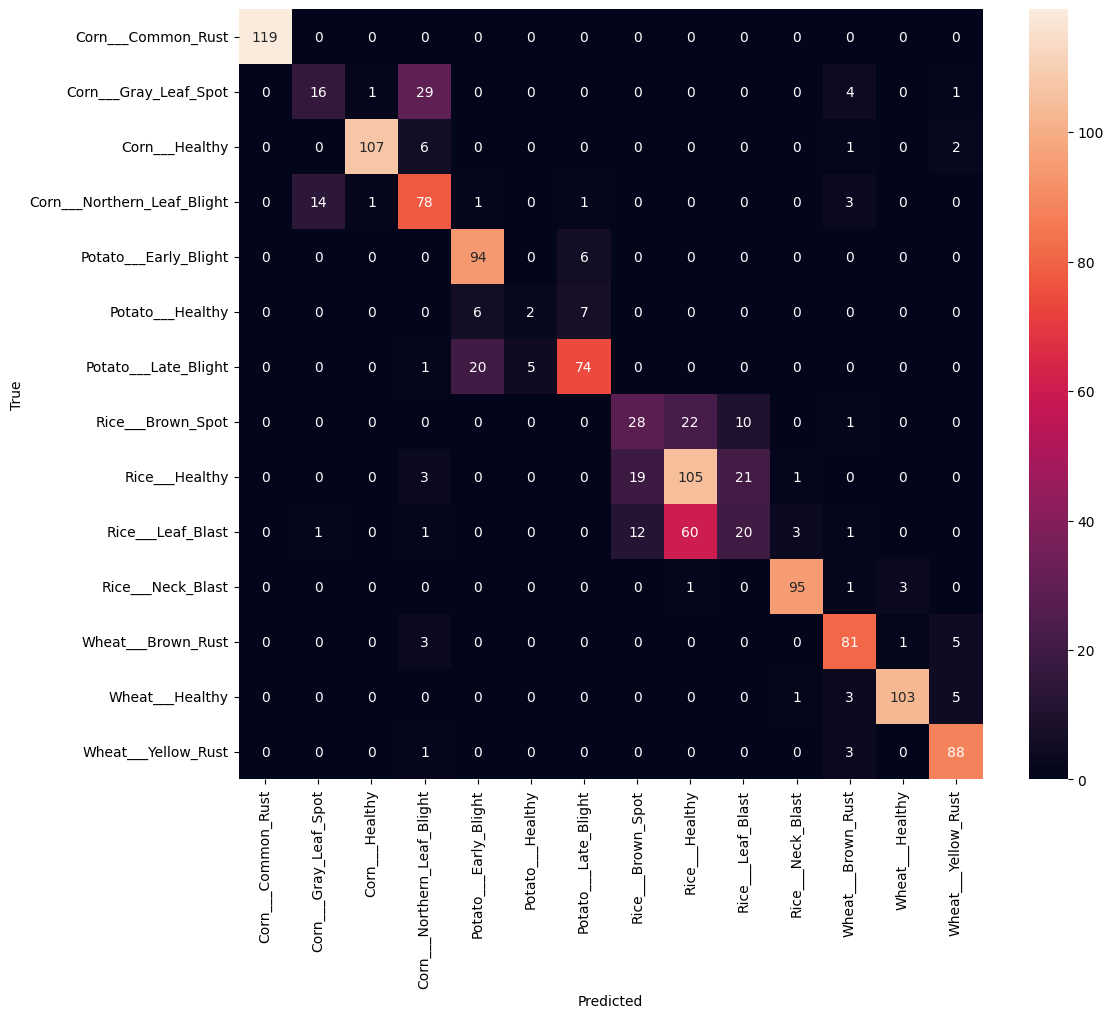

In [43]:
#confusion matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()